In [277]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
import re
import warnings

import lightgbm as lgb
import shap

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mutual_info_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso

import pickle

In [214]:
warnings.filterwarnings(action="ignore")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# 1.0. Data Reading and Cleaning

In [215]:
dataset = './data/tabela-fipe-historico-precos.csv'
df_raw = pd.read_csv(dataset)

In [216]:
df_raw.head()

,Unnamed: 0,codigoFipe,marca,modelo,anoModelo,mesReferencia,anoReferencia,valor
0,0,038003-2,Acura,Integra GS 1.8,1992,11,2016,13041.0
1,1,038001-6,Acura,NSX 3.0,1995,3,2013,52339.0
2,2,038003-2,Acura,Integra GS 1.8,1992,3,2018,12423.0
3,3,038002-4,Acura,Legend 3.2/3.5,1998,5,2016,31067.0
4,4,038002-4,Acura,Legend 3.2/3.5,1998,2,2019,26381.0


In [217]:
df_raw.shape

(466020, 8)

In [218]:
df_raw.columns

Index(['Unnamed: 0', 'codigoFipe', 'marca', 'modelo', 'anoModelo',
       'mesReferencia', 'anoReferencia', 'valor'],
      dtype='object')

In [219]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466020 entries, 0 to 466019
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     466020 non-null  int64  
 1   codigoFipe     466020 non-null  object 
 2   marca          466020 non-null  object 
 3   modelo         466020 non-null  object 
 4   anoModelo      466020 non-null  int64  
 5   mesReferencia  466020 non-null  int64  
 6   anoReferencia  466020 non-null  int64  
 7   valor          466020 non-null  float64
dtypes: float64(1), int64(4), object(3)
memory usage: 28.4+ MB


<Axes: ylabel='Frequency'>

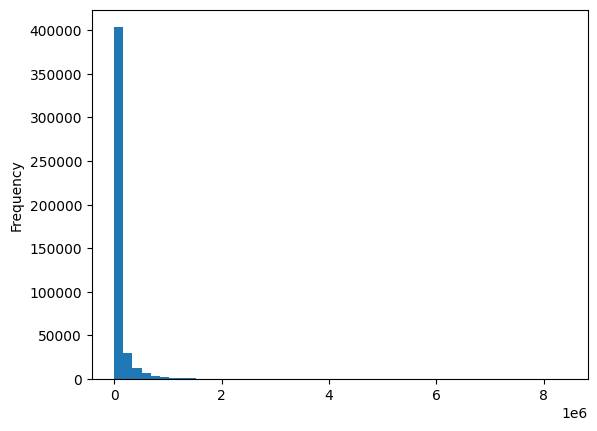

In [220]:
df_raw['valor'].plot(kind='hist', bins = 50)

## 1.1. Data Cleaning

In [221]:
df1 = df_raw.copy()
df1.shape

(466020, 8)

In [222]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466020 entries, 0 to 466019
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     466020 non-null  int64  
 1   codigoFipe     466020 non-null  object 
 2   marca          466020 non-null  object 
 3   modelo         466020 non-null  object 
 4   anoModelo      466020 non-null  int64  
 5   mesReferencia  466020 non-null  int64  
 6   anoReferencia  466020 non-null  int64  
 7   valor          466020 non-null  float64
dtypes: float64(1), int64(4), object(3)
memory usage: 28.4+ MB


In [223]:
def snake_case(c):
    return re.sub(r'(?<!^)(?=[A-Z])', '_', c).lower()
df1.columns = [snake_case(c) for c in df1.columns]

categorical_columns = list(df1.dtypes[df1.dtypes == 'object'].index)
for c in categorical_columns:
    df1[c] = df1[c].str.lower().str.replace(' ', '_')
    df1[c] = df1[c].str.replace('-','_')

In [224]:
# couldn't figure out how to not import this column while reading the dataset
df1.drop(columns=['unnamed: 0'], inplace=True)

### 1.1.1. Checking Data Types

In [225]:
df1.dtypes

codigo_fipe        object
marca              object
modelo             object
ano_modelo          int64
mes_referencia      int64
ano_referencia      int64
valor             float64
dtype: object

### 1.1.2. Checking for Missing Values

In [226]:
df1.isna().sum()

codigo_fipe       0
marca             0
modelo            0
ano_modelo        0
mes_referencia    0
ano_referencia    0
valor             0
dtype: int64

### 1.1.3. Checking for Duplicated Values

In [227]:
df1.duplicated().sum()

0

# 2.0. Feature Engineering

In [228]:
df2 = df1.copy()

In [229]:
media_por_marca = df2.groupby('marca')['valor'].mean()

df2['classificacao_marca'] = df2['marca'].map(
        lambda marca: (
        'economical' if media_por_marca[marca] <= 50_000 else
        'affordable' if media_por_marca[marca] <= 100_000 else
        'mid_range' if media_por_marca[marca] <= 500_000 else
        'luxury' if media_por_marca[marca] <= 1_000_000 else
        'super_luxury' if media_por_marca[marca] <= 5_000_000 else
        'ultra_luxury'
    )
)



## 2.2. Spliting Data

In [332]:
df_full_train, df_test = train_test_split(df2, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [333]:
len(df_train), len(df_val), len(df_test)

(279612, 93204, 93204)

In [334]:
X_train = df_train.reset_index(drop=True)
X_val = df_val.reset_index(drop=True)
X_test = df_test.reset_index(drop=True)

In [335]:
y_train = np.log1p(X_train.valor.values)
y_val = np.log1p(X_val.valor.values)
y_test = np.log1p(X_test.valor.values)

In [336]:
X_train.drop(columns=['valor'], inplace=True)
X_val.drop(columns=['valor'], inplace=True)
X_test.drop(columns=['valor'], inplace=True)

# 3.0. Exploratory Data Analysis

In [235]:
df3 = df_full_train.copy()

In [236]:
df3.describe()

,ano_modelo,mes_referencia,ano_referencia,valor
count,372816.000000,372816.000000,372816.000000,3.728160e+05
mean,2008.979301,6.453492,2015.183541,1.158133e+05
std,10.004937,3.417041,5.676673,3.237863e+05
min,1985.000000,1.000000,2001.000000,1.871000e+03
25%,2000.000000,4.000000,2011.000000,1.938200e+04
50%,2009.000000,6.000000,2017.000000,3.942300e+04
75%,2020.000000,9.000000,2020.000000,8.499000e+04
max,2023.000000,12.000000,2022.000000,8.400000e+06


## 3.1. Target Feature

In [237]:
print(f'the mean of the column "valor" is: {df3.valor.mean()}')
print(f'the median of the column "valor" is: {df3.valor.median()}')

the mean of the column "valor" is: 115813.2970983005
the median of the column "valor" is: 39423.0


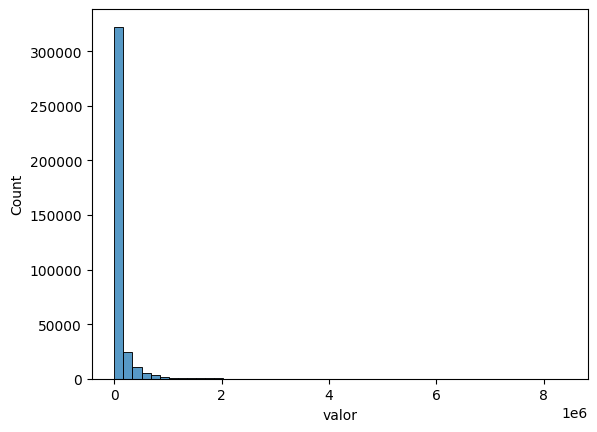

In [238]:
sns.histplot(df3.valor, bins=50)
plt.show()

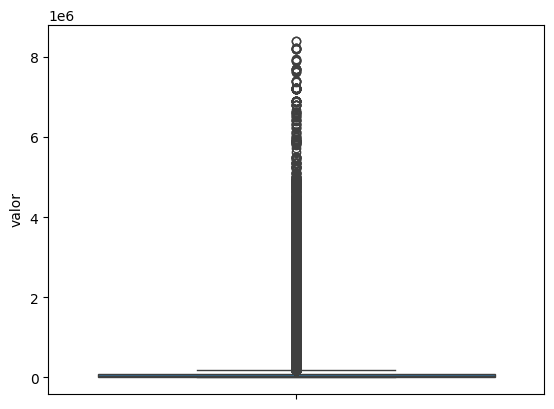

In [239]:
sns.boxplot(data=df3.valor)
plt.show()

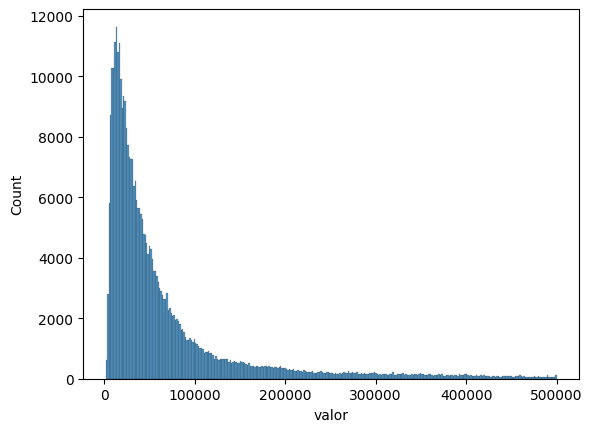

In [240]:
sns.histplot(df3[df3['valor'] < 500_000]['valor'])
plt.show()

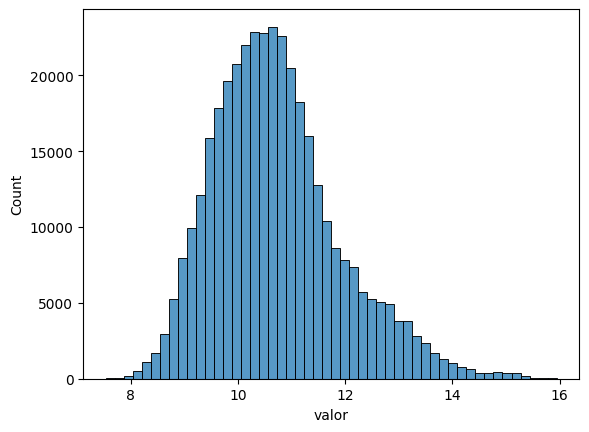

In [241]:
# log transformation will help us with the skewed distribution
val_log = np.log1p(df3['valor'])
sns.histplot(val_log, bins=50)
plt.show()

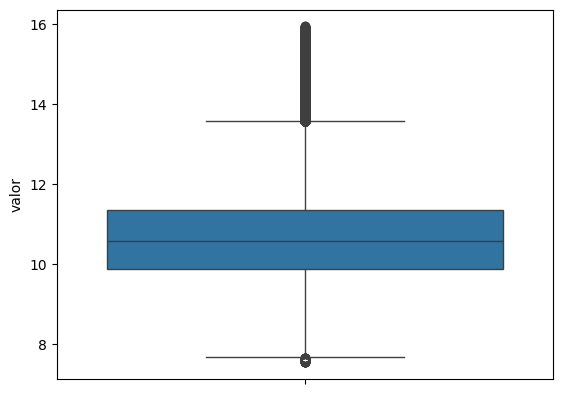

In [113]:
sns.boxplot(data=val_log)
plt.show()

## 3.2. Categorical Features

In [242]:
cat_cols = list(df3.dtypes[df3.dtypes == 'object'].index)
df3[cat_cols].nunique()

codigo_fipe            5189
marca                    84
modelo                 5265
classificacao_marca       5
dtype: int64

### 3.2.1. Valor Ratio

In [250]:
def valor_rate_difference(df, column):
    valor_rate_by_column = df.groupby(column)['valor'].mean()
    valor_rate_diff = valor_rate_by_column - df3['valor'].mean()
    return valor_rate_diff

In [251]:
valor_rate_difference(df3, 'modelo').sort_values(ascending=False)

modelo
sf_90_spider_4.0_v8_bi_turbo_(híbrido)      8.284187e+06
aventador_770_4_svj_roadster_v12            7.844317e+06
cullinan_black_badge_6.7_v12_aut.           7.412104e+06
sf_90_stradale_4.0_v8_bi_turbo_(híbrido)    7.171022e+06
aventador_lp_770_4_svj                      7.160423e+06
                                                ...     
belina_l_1.8/_1.6                          -1.126883e+05
corcel_ii_l                                -1.127258e+05
147_furgão_(todos)                         -1.132093e+05
laika_1.5                                  -1.133615e+05
panorama_c/cl                              -1.133863e+05
Name: valor, Length: 5265, dtype: float64

In [252]:
valor_rate_difference(df3, 'marca').sort_values(ascending=False)

marca
rolls_royce     3.604053e+06
mclaren         2.734221e+06
lamborghini     2.171798e+06
ferrari         9.109449e+05
aston_martin    8.260955e+05
                    ...     
saturn         -1.048379e+05
gurgel         -1.054938e+05
daihatsu       -1.058006e+05
lada           -1.078561e+05
asia_motors    -1.087191e+05
Name: valor, Length: 84, dtype: float64

### 3.3.2. Mutual Information

In [253]:
def mutual_valor_score(series):
    return mutual_info_score(series, df3.valor)

In [254]:
mi = df3[cat_cols].apply(mutual_valor_score)
mi.sort_values(ascending=False)

modelo                 6.924044
codigo_fipe            6.920871
marca                  2.342664
classificacao_marca    0.678938
dtype: float64

In [255]:
mutual_info_data = {
    'Feature': ['modelo', 'codigo_fipe', 'marca', 'classificacao_marca'],
    'Classification': ['Strong', 'Strong', 'Moderate', 'Weak'],
    'Mutual Info Score': [6.924044, 6.920871, 2.342664, 0.678938]
}

importance = pd.DataFrame(mutual_info_data)
print(tabulate(importance, headers='keys', tablefmt='pretty'))

+---+---------------------+----------------+-------------------+
|   |       Feature       | Classification | Mutual Info Score |
+---+---------------------+----------------+-------------------+
| 0 |       modelo        |     Strong     |     6.924044      |
| 1 |     codigo_fipe     |     Strong     |     6.920871      |
| 2 |        marca        |    Moderate    |     2.342664      |
| 3 | classificacao_marca |      Weak      |     0.678938      |
+---+---------------------+----------------+-------------------+


## 3.3. Numerical Features

In [256]:
num_cols = list(df3.dtypes[df3.dtypes != 'object'].index)

In [257]:
num_cols

['ano_modelo', 'mes_referencia', 'ano_referencia', 'valor']

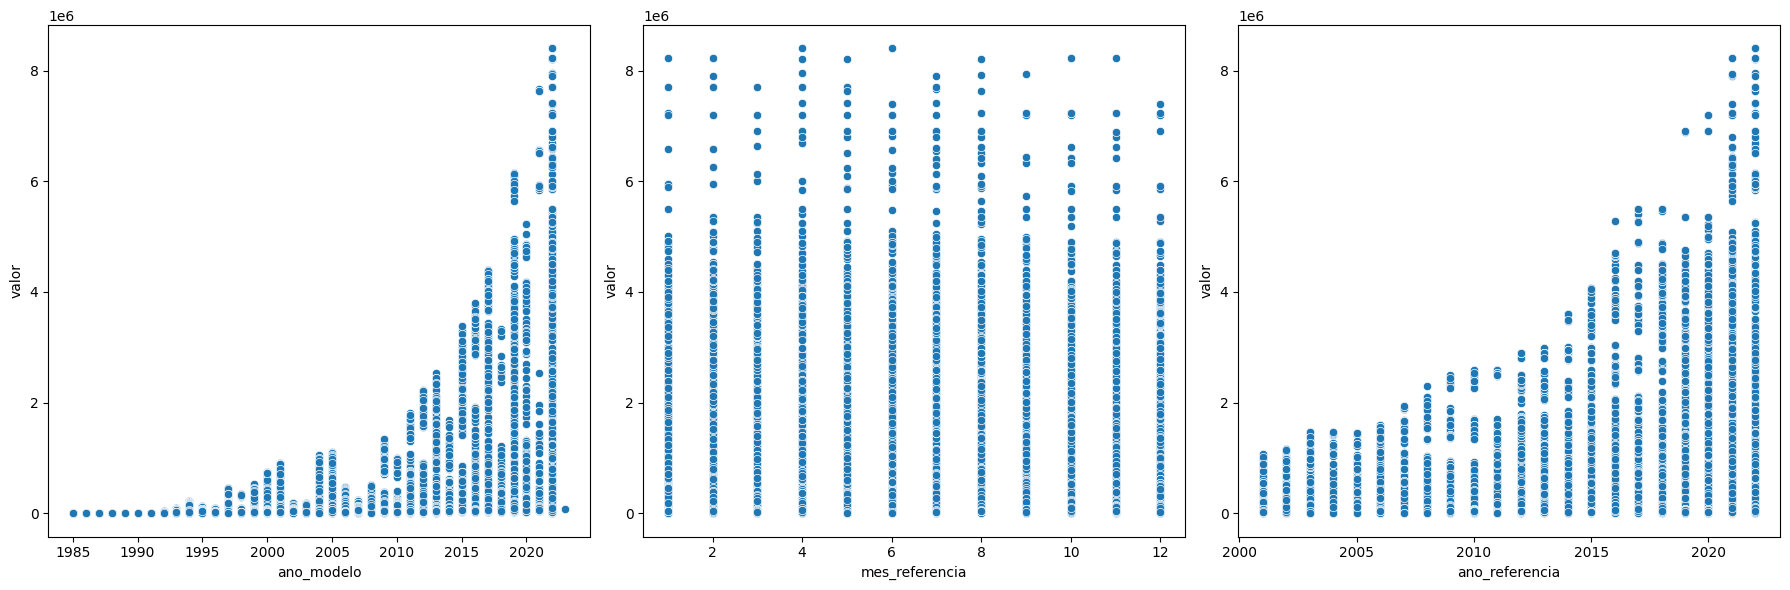

In [258]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.scatterplot(x='ano_modelo', y='valor', data=df3, ax=axes[0])
sns.scatterplot(x='mes_referencia', y='valor', data=df3, ax=axes[1])
sns.scatterplot(x='ano_referencia', y='valor', data=df3, ax=axes[2])

plt.tight_layout()
plt.show()

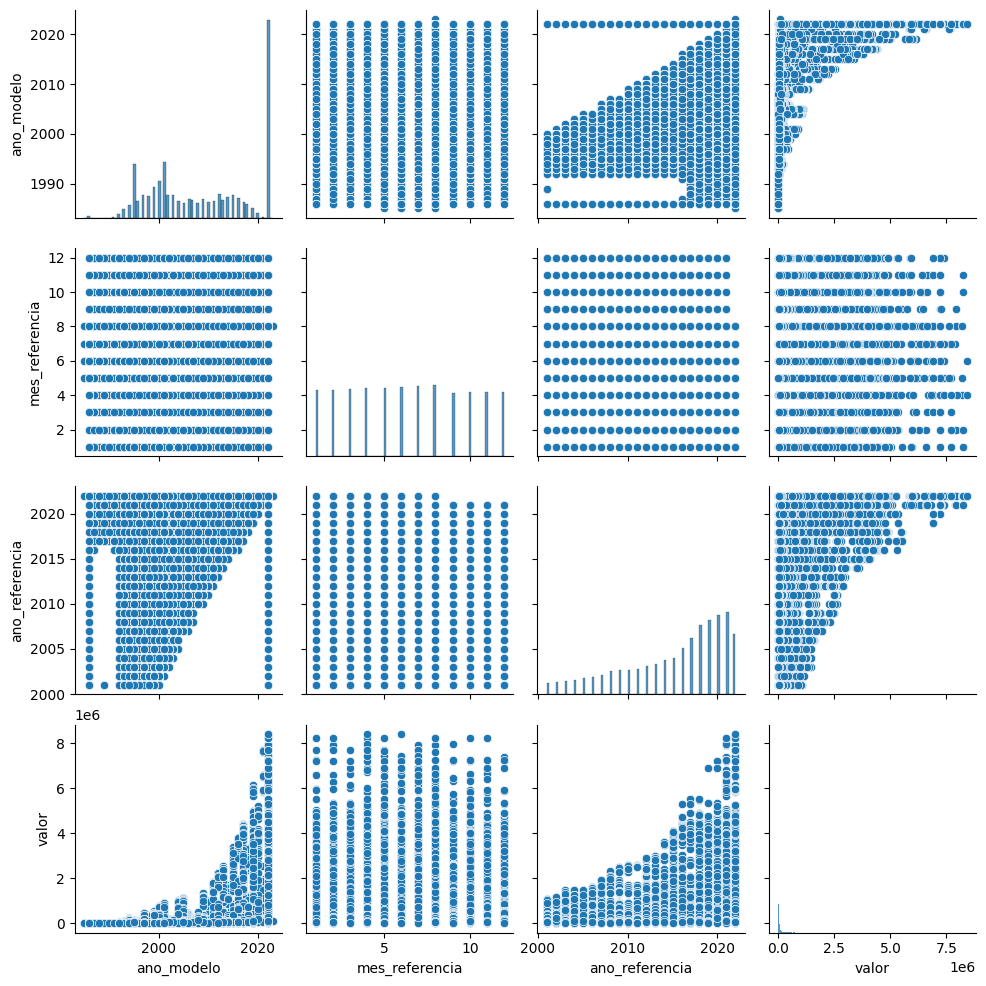

In [259]:
sns.pairplot(df3[['ano_modelo', 'mes_referencia', 'ano_referencia', 'valor']])
plt.show()

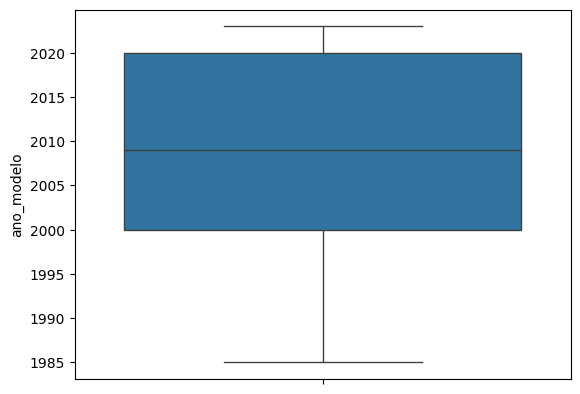

In [260]:
sns.boxplot(data=df3.ano_modelo)
plt.show()

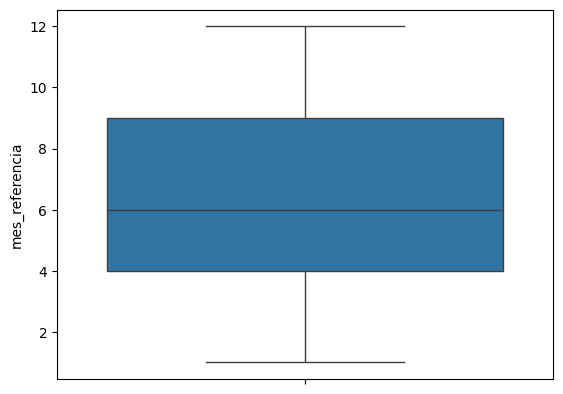

In [261]:
sns.boxplot(data=df3.mes_referencia)
plt.show()

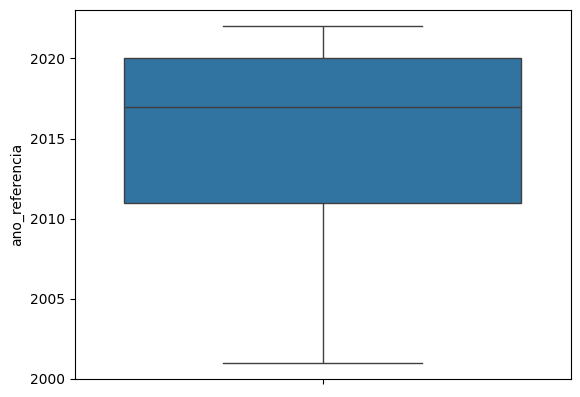

In [262]:
sns.boxplot(data=df3.ano_referencia)
plt.show()

### 3.3.1. Correlation with Valor

In [263]:
corrs = df3[num_cols].corrwith(df3.valor)
corrs_sorted = corrs.sort_values(ascending=False)

In [264]:
print(corrs_sorted)

valor             1.000000
ano_modelo        0.262643
ano_referencia    0.077532
mes_referencia   -0.001158
dtype: float64


In [130]:
correlation_data = {
    'Feature': [ 'ano_modelo', 'ano_referencia', 'mes_referencia'],
    'Classification': ['Moderate', 'Weak', 'Weak'],
    'Correlation with "valor"': [0.262643, 0.077532, -0.001158]
}

importance = pd.DataFrame(correlation_data)
print(tabulate(importance, headers='keys', tablefmt='pretty'))

+---+----------------+----------------+--------------------------+
|   |    Feature     | Classification | Correlation with "valor" |
+---+----------------+----------------+--------------------------+
| 0 |   ano_modelo   |    Moderate    |         0.262643         |
| 1 | ano_referencia |      Weak      |         0.077532         |
| 2 | mes_referencia |      Weak      |        -0.001158         |
+---+----------------+----------------+--------------------------+


### 3.3.2. Heatmap

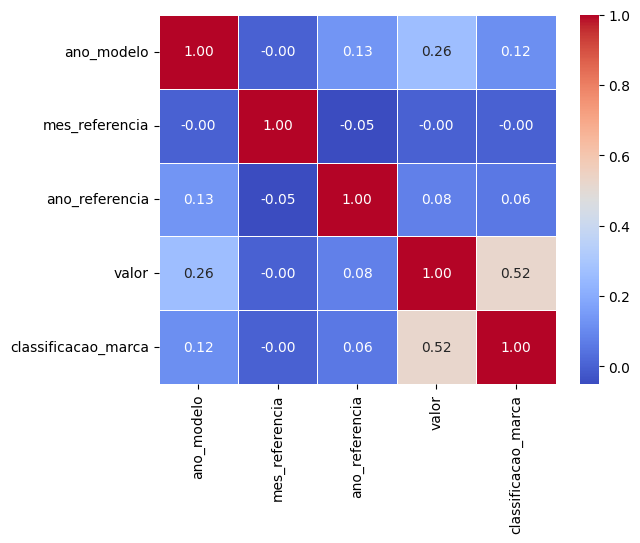

In [131]:
sns.heatmap(df3[num_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

# 4.0. Feature Selection

## 4.1. Permutation Importance w/ LightGBM

In [265]:
model = lgb.LGBMRegressor(random_state=42)

# Convert categorical columns to categorical dtype
for col in cat_cols:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

model.fit(X_train, y_train, categorical_feature=categorical_columns)

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance Mean': perm_importance.importances_mean,
    'Importance Std': perm_importance.importances_std
}).sort_values(by='Importance Mean', ascending=False)

print(importance_df)


               Feature  Importance Mean  Importance Std
3           ano_modelo         0.805217        0.003028
1                marca         0.796975        0.001857
0          codigo_fipe         0.110520        0.000232
5       ano_referencia         0.066199        0.000369
2               modelo         0.007016        0.000027
6  classificacao_marca         0.002737        0.000024
4       mes_referencia         0.000317        0.000006


In [272]:
importance_data = {
    'Feature': ['ano_modelo', 'marca', 'codigo_fipe', 'ano_referencia', 'modelo', 'classificacao_marca', 'mes_referencia'],
    'Classification': ['Very Important', 'Very Important', 'Very Important', 'Important', 'Important', 'Not Important', 'Not Important'],
    'Importance Mean': [0.805217, 0.796975, 0.110520, 0.066199, 0.007016, 0.002737, 0.000317],
    'Importance Std': [0.003028, 0.001857, 0.000232, 0.000369, 0.000027, 0.000024, 0.000006]
}

importance = pd.DataFrame(importance_data)
print(tabulate(importance, headers='keys', tablefmt='pretty'))


+---+---------------------+----------------+-----------------+----------------+
|   |       Feature       | Classification | Importance Mean | Importance Std |
+---+---------------------+----------------+-----------------+----------------+
| 0 |     ano_modelo      | Very Important |    0.805217     |    0.003028    |
| 1 |        marca        | Very Important |    0.796975     |    0.001857    |
| 2 |     codigo_fipe     | Very Important |     0.11052     |    0.000232    |
| 3 |   ano_referencia    |   Important    |    0.066199     |    0.000369    |
| 4 |       modelo        |   Important    |    0.007016     |    2.7e-05     |
| 5 | classificacao_marca | Not Important  |    0.002737     |    2.4e-05     |
| 6 |   mes_referencia    | Not Important  |    0.000317     |     6e-06      |
+---+---------------------+----------------+-----------------+----------------+


## 4.2. Shapley Additive Explanations (SHAP)

In [273]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

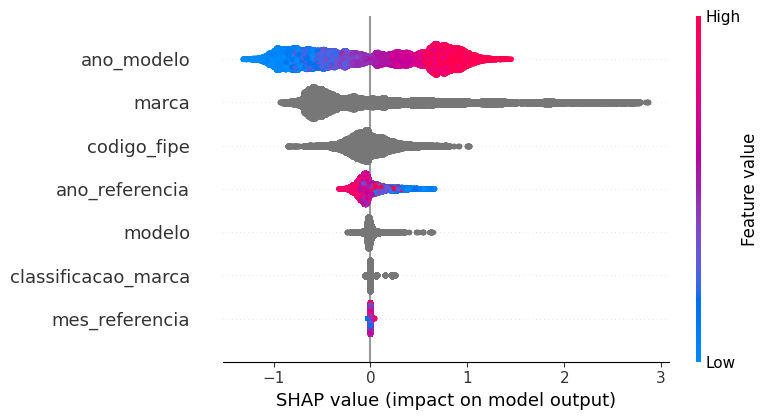

In [274]:
shap.summary_plot(shap_values, X_test)

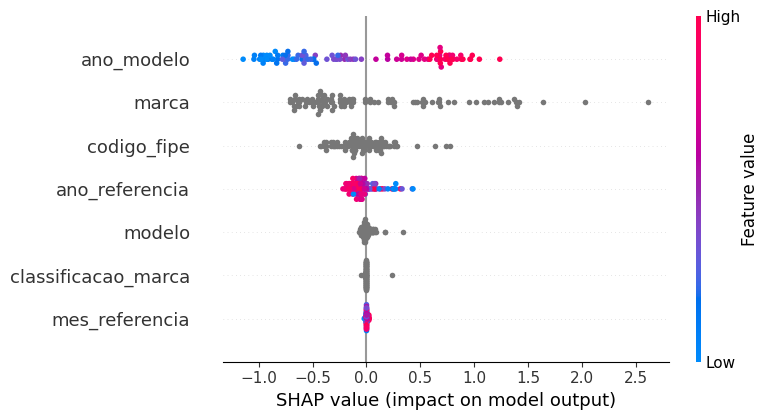

In [275]:
X_test_sample = X_test.sample(100)
shap_values_sample = explainer.shap_values(X_test_sample)
shap.summary_plot(shap_values_sample, X_test_sample)


# 4.3. Final Selection

In [337]:
freq_encoding_map = X_train['marca'].value_counts() / len(X_train)
X_train['marca_freq_encoded'] = X_train['marca'].map(freq_encoding_map)
X_val['marca_freq_encoded'] = X_val['marca'].map(freq_encoding_map)
X_test['marca_freq_encoded'] = X_test['marca'].map(freq_encoding_map)

X_train = pd.get_dummies(X_train, columns=['classificacao_marca'], drop_first=True)
X_val = pd.get_dummies(X_val, columns=['classificacao_marca'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['classificacao_marca'], drop_first=True)

categorical_cols = ['marca_freq_encoded'] + [col for col in X_train.columns if col.startswith('classificacao_marca')]
numerical_cols = ['ano_modelo', 'ano_referencia', 'mes_referencia']

# 5.0. Training Models

In [338]:
def ml_error_to_df(model_name, model, X, y, y_pred):
    y_real = np.expm1(y)  # Reverte log1p aplicado ao target
    y_pred_real = np.expm1(y_pred)  # Reverte log1p aplicado às previsões

    mae = mean_absolute_error(y_real, y_pred_real)
    mape = mean_absolute_percentage_error(y_real, y_pred_real)
    rmse = np.sqrt(mean_squared_error(y_real, y_pred_real))

    cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())  # turning neg mse into rmse

    result_df = pd.DataFrame({
        "Model Name": [model_name],
        "MAE": [mae],
        "MAPE": [mape],
        "RMSE": [rmse],
        "CV RMSE": [cv_rmse]
    })

    return result_df


## 5.1. Linear Models

In [339]:
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Normaliza variáveis numéricas
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', 'passthrough', categorical_cols)
    ]
)

### 5.1.1. Linear Regression

In [340]:
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['ano_modelo',
                                                   'ano_referencia',
                                                   'mes_referencia']),
                                                 ('cat', 'passthrough',
                                                  ['marca_freq_encoded',
                                                   'classificacao_marca_economical',
                                                   'classificacao_marca_luxury',
                                                   'classificacao_marca_mid_range',
                                                   'classificacao_marca_super_luxury'])])),
                ('regressor', LinearRegression())])

In [341]:
y_pred_lr = pipeline_lr.predict(X_test)

In [342]:
error_lr = ml_error_to_df("Linear Regression", pipeline_lr, X_test, y_test, y_pred_lr)
error_lr


,Model Name,MAE,MAPE,RMSE,CV RMSE
0,Linear Regression,53951.922344,0.478402,198395.961128,0.5646


### 5.1.2. Ridge 

In [343]:
pipeline_ridge = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

In [344]:
pipeline_ridge.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['ano_modelo',
                                                   'ano_referencia',
                                                   'mes_referencia']),
                                                 ('cat', 'passthrough',
                                                  ['marca_freq_encoded',
                                                   'classificacao_marca_economical',
                                                   'classificacao_marca_luxury',
                                                   'classificacao_marca_mid_range',
                                                   'classificacao_marca_super_luxury'])])),
                ('regressor', Ridge())])

In [345]:
y_pred_ridge = pipeline_ridge.predict(X_test)

In [346]:
error_ridge = ml_error_to_df("Ridge Regression", pipeline_ridge, X_test, y_test, y_pred_ridge)
error_ridge

,Model Name,MAE,MAPE,RMSE,CV RMSE
0,Ridge Regression,53954.264981,0.478392,198435.528027,0.564601


### 5.1.3. Lasso

In [347]:
pipeline_lasso = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso(max_iter=10000))
])

In [348]:

pipeline_lasso.fit(X_test, y_test)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['ano_modelo',
                                                   'ano_referencia',
                                                   'mes_referencia']),
                                                 ('cat', 'passthrough',
                                                  ['marca_freq_encoded',
                                                   'classificacao_marca_economical',
                                                   'classificacao_marca_luxury',
                                                   'classificacao_marca_mid_range',
                                                   'classificacao_marca_super_luxury'])])),
                ('regressor', Lasso(max_iter=10000))])

In [349]:
y_pred_lasso = pipeline_lasso.predict(X_test)

In [350]:
error_lasso = ml_error_to_df("Lasso Regression", pipeline_lasso, X_test, y_test, y_pred_lasso)
error_lasso

,Model Name,MAE,MAPE,RMSE,CV RMSE
0,Lasso Regression,95330.416545,1.205358,337615.724729,1.188603


In [353]:
error_final = pd.concat([error_lr, error_ridge, error_lasso]).reset_index(drop=True)
error_final

,Model Name,MAE,MAPE,RMSE,CV RMSE
0,Linear Regression,53951.922344,0.478402,198395.961128,0.564600
1,Ridge Regression,53954.264981,0.478392,198435.528027,0.564601
2,Lasso Regression,95330.416545,1.205358,337615.724729,1.188603


# 6.0. Model Tuning

In [358]:
param_grid = {
    'regressor__alpha': [0.01, 0.1, 1, 10, 100, 1000, 10000],
    'regressor__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'regressor__fit_intercept': [True, False]
}

grid_search = GridSearchCV(
    estimator=pipeline_ridge,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)


In [359]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['ano_modelo',
                                                                          'ano_referencia',
                                                                          'mes_referencia']),
                                                                        ('cat',
                                                                         'passthrough',
                                                                         ['marca_freq_encoded',
                                                                          'classificacao_marca_economical',
                                                                          'classificacao_marca_luxury',
                                                                          'classificacao_marca_mid_range',
                                                                          'classificacao_marca_super_luxury'])])),
                                       ('regressor', Ridge())]),
             n_jobs=-1,
             param_grid={'regressor__alpha': [0.01, 0.1, 1, 10, 100, 1000,
                                              10000],
                         'regressor__fit_intercept': [True, False],
                         'regressor__solver': ['auto', 'svd', 'cholesky',
                                               'lsqr', 'sparse_cg', 'sag',
                                               'saga']},
             scoring='neg_mean_squared_error')

In [360]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = -grid_search.best_score_ 

In [361]:
print("Best Parameters:", best_params)
print("Best RMSE on CV:", np.sqrt(best_score))

Best Parameters: {'regressor__alpha': 0.01, 'regressor__fit_intercept': True, 'regressor__solver': 'sag'}
Best RMSE on CV: 0.5651597220078626


# 7.0. Model Serving

In [363]:
with open('./ridge_model_with_preprocessing.pkl', 'wb') as f:
    pickle.dump(grid_search.best_estimator_, f)